In [1]:
import pandas as pd
import numpy as np
import music21 as m21

In [306]:
import logging
logger = logging.getLogger('default')

In [291]:
test_score = m21.converter.parseFile('../output/mid/102d386f88d156c5cf2f2bf10c8a1e26373b5c94.mid')
test_score.makeMeasures().show('midi')

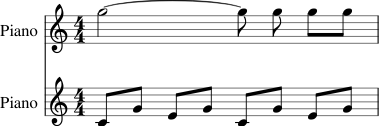

In [292]:
test_measure = test_score.measure(2)
test_measure.show()

In [307]:
from collections import Counter

DEFAULT_OCTAVE = 4

def get_normalized_pitches(chord):
    """
    Extract list of pitches from chord
    """
    assert chord
    
    pitches = {n.pitch.nameWithOctave: n.pitch for n in chord}
    return pitches.values()

def get_cumulative_durations_by_pitch(stream):
    """
    Extact cumulative duration of each pitch in the stream
    """
    assert stream
    
    notes_counter = Counter()
    chord_stream = stream.flat.chordify()
    
    for chord in chord_stream.notes:
        # try to move all the notes to single octave
        chord = chord.closedPosition(forceOctave=DEFAULT_OCTAVE)
        
        for pitch in get_normalized_pitches(chord):
            notes_counter[pitch] += chord.duration.quarterLength
        
    return notes_counter     

def extract_chord(measure, min_length_relative=1/8):
    """
    Extract chord from given measure
    :param min_length_relative: Minimal proportion of cumulative duration of given note in a measure for it to be added
    """
    assert measure
    assert 1 >= min_length_relative >= 0
    
    measure_duration = measure.duration.quarterLength
    cumulative_note_durations = get_cumulative_durations_by_pitch(measure)
    
    significant_notes = [p for p, d in cumulative_note_durations.items() if d >= min_length_relative * measure_duration]
    return m21.chord.Chord(significant_notes)

def extract_chords(stream):
    
    measures = list(stream.getElementsByClass('Measure'))
    
    if not measures:
        return extract_chords(stream.makeMeasures())
    
    result = stream.cloneEmpty()
    
    for i, measure in enumerate(measures):
        measure_chord = extract_chord(measure)
        result.append(measure_chord)
        logger.info('Measure #%d processed', i)
        
    return result

In [303]:
result = extract_chords(test_score)

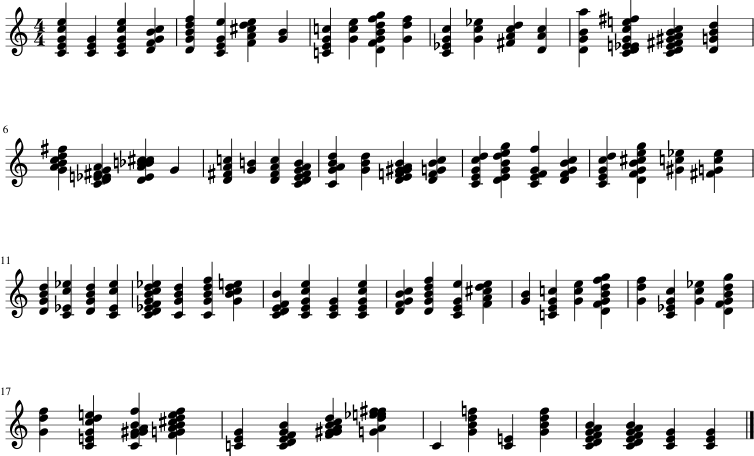

In [308]:
result.show()

In [309]:
result.show('midi')